In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
import numpy as np
import h5py
import glob
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,Conv2D,BatchNormalization,
    DepthwiseConv2D,Activation,
    AveragePooling2D,SeparableConv2D,
    Flatten,Dense,
    Dropout,GlobalAveragePooling2D,Reshape, Multiply,
)
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [17]:
BASE_PATH_CROSS = '/content/drive/MyDrive/Final Project data (1)/Cross'
BASE_PATH_INTRA = '/content/drive/MyDrive/Final Project data (1)/Intra'

CROSS_TRAIN_DIR = os.path.join(BASE_PATH_CROSS, 'train/')
TEST1_DIR = os.path.join(BASE_PATH_CROSS, 'test1/')
TEST2_DIR = os.path.join(BASE_PATH_CROSS, 'test2/')
TEST3_DIR = os.path.join(BASE_PATH_CROSS, 'test3/')
INTRA_TRAIN_DIR = os.path.join(BASE_PATH_INTRA, 'train/')
INTRA_TEST_DIR = os.path.join(BASE_PATH_INTRA, 'test/')

# Constants
N_CHANNELS = 248
TASKS = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
task_to_label = {task: i for i, task in enumerate(TASKS)}
DOWNSAMPLE_FACTOR = 10
WINDOW_SIZE = 150
STEP = 50

#loading and preprocessing funcs
def get_file_paths(directory):
    files = glob.glob(f"{directory}/*.h5")
    if not files:
        raise FileNotFoundError(f"No file found")
    return files

def load_data(file_paths):
    data = []
    labels = []
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        task = None
        if 'rest' in filename:
            task = 'rest'
        elif 'motor' in filename:
            task = 'task_motor'
        elif 'story' in filename or 'math' in filename:
            task = 'task_story_math'
        elif 'working' in filename or 'memory' in filename:
            task = 'task_working_memory'

        if task:
            labels.append(task_to_label[task])
            with h5py.File(file_path, 'r') as f:
                dataset_name = list(f.keys())[0]
                matrix = f[dataset_name][()]
                data.append(matrix)
    return np.array(data), np.array(labels)

def windowing(data, labels, window_size, step):
    X_win, y_win = [], []
    for i in range(data.shape[0]):
        n_windows = (data.shape[2] - window_size) // step + 1
        for j in range(n_windows):
            start=j*step
            end = start +window_size
            X_win.append(data[i, :, start:end])
            y_win.append(labels[i])
    return np.array(X_win), np.array(y_win)

def normalize_data(data):
    """function for appluing time wise z-score normalization to each window"""
    n_samples, n_channels, n_timesteps = data.shape
    # reshape for scaler: (samples * channels, timesteps)
    reshaped_data = data.reshape(n_samples * n_channels, n_timesteps)
    scaler = StandardScaler()

    scaled_data = scaler.fit_transform(reshaped_data)
    #reshap back to original shape
    return scaled_data.reshape(n_samples, n_channels, n_timesteps)

def augment_data(data, labels, noise_factor=0.05, scale_factor_range=(0.9, 1.1)):
    """applies noises and scaling augmentation"""
    augmented_data, augmented_labels = [], []
    for i in range(len(data)):
        original_sample = data[i]
        original_label = labels[i]
        # add org sample
        augmented_data.append(original_sample)
        augmented_labels.append(original_label)
        # add augmented sample
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=original_sample.shape)
        scaler = np.random.uniform(low=scale_factor_range[0], high=scale_factor_range[1])
        augmented_sample = (original_sample + noise) * scaler
        augmented_data.append(augmented_sample)
        augmented_labels.append(original_label)
    return np.array(augmented_data), np.array(augmented_labels)


# preproccessing
def preprocess_pipeline(base_dir, is_training=True, output_format='2d'):

    files = get_file_paths(base_dir)
    X, y = load_data(files)
    X_ds = X[:, :, ::DOWNSAMPLE_FACTOR]
    print(f"downsampled data shape: {X_ds.shape}")

    X_win, y_win = windowing(X_ds, y, WINDOW_SIZE, STEP)
    print(f"windowed data shape: {X_win.shape}")

    X_norm = normalize_data(X_win)

    if is_training:
        X_aug, y_aug = augment_data(X_norm, y_win)
        print(f"augmented data shape: {X_aug.shape}")
        final_X, final_y = X_aug, y_aug
    else:
        final_X, final_y = X_norm, y_win

    if output_format == '2d':
        # Reshape for EEGNet/2D CNNs by adding a final dimension
        final_X = final_X[..., np.newaxis]
        print(f"Final data shape for 2D model: {final_X.shape}")
    elif output_format == '1d':
        # Reshape for Simple/1D CNNs by swapping the last two axes
        final_X = np.transpose(final_X, (0, 2, 1))
        print(f"final data shape for 1D model: {final_X.shape}")
    else:
        raise ValueError("Invalid output_format")

    return final_X, final_y

# EEGNet with ATTENTION MODEL

In [20]:
def squeeze_excite_block(input_tensor, ratio=16):
    """Squeeze and Excite block for channelwise attention"""
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def EEGNet_with_Attention(
    nb_classes, Chans=248, Samples=150, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16
):
    """
    EEGNet model with a squeeze and excite attention block
    """
    input1 = Input(shape=(Chans, Samples, 1))

    #temporal convolution
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)

    # depth wwise convolution
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    # attention Block
    block1_attention = squeeze_excite_block(block1)

    # block 2 separable convolution
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='valid')(block1_attention)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    # classification head
    flatten = Flatten(name='flatten')(block2)
    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(0.25))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

In [8]:
def EEGNet_with_Attention_Regularized(
    nb_classes, Chans=248, Samples=150, dropoutRate=0.5, kernLength=64,
    F1=8, D=2, F2=16, l2_lambda=0.001
):
    """
    EEGNet model with squeeze and excite attention and L2 regularization
    """
    input1 = Input(shape=(Chans, Samples, 1))

    # block 1: temporal conv
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    # attention. block
    block1_attention = squeeze_excite_block(block1)

    # block 2: seperable conv with l2 regularization arguments
    block2 = SeparableConv2D(
        F2, (1, 16),
        use_bias=False,
        padding='valid',
        depthwise_regularizer=l2(l2_lambda),
        pointwise_regularizer=l2(l2_lambda)
    )(block1_attention)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)


    # clasification head with L2 regularization
    flatten = Flatten(name='flatten')(block2)
    dense = Dense(nb_classes, kernel_constraint=max_norm(0.25), kernel_regularizer=l2(l2_lambda))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)


    return Model(inputs=input1, outputs=softmax)

try:
    X_train_cross_final, y_train_cross_final = preprocess_pipeline(CROSS_TRAIN_DIR, is_training=True)
    X_train_intra_final, y_train_intra_final = preprocess_pipeline(INTRA_TRAIN_DIR, is_training=True)
    X_test1_final, y_test1_final = preprocess_pipeline(TEST1_DIR, is_training=False)
    X_test2_final, y_test2_final = preprocess_pipeline(TEST2_DIR, is_training=False)
    X_test3_final, y_test3_final = preprocess_pipeline(TEST3_DIR, is_training=False)
    X_test_intra_final, y_test_intra_final = preprocess_pipeline(INTRA_TEST_DIR, is_training=False)

    model = EEGNet_with_Attention_Regularized(
        nb_classes=len(TASKS),
        Chans=N_CHANNELS,
        Samples=WINDOW_SIZE,
        dropoutRate=0.6,
        l2_lambda=0.001
    )
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    checkpoint = ModelCheckpoint('eegnet_cross.h5', monitor='val_loss', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

    history_cross = model.fit(
        X_train_cross_final, y_train_cross_final,
        batch_size=32,
        epochs=100,
        validation_split=0.2,
        callbacks=[checkpoint, early_stop, reduce_lr]
    )

    model.load_weights('eegnet_attention_cross_regularized.h5')
    loss1, acc1 = model.evaluate(X_test1_final, y_test1_final, verbose=0)
    loss2, acc2 = model.evaluate(X_test2_final, y_test2_final, verbose=0)
    loss3, acc3 = model.evaluate(X_test3_final, y_test3_final, verbose=0)

    print("\nCross Results:")
    print(f"Test set 1 accuracy: {acc1:.4f}")
    print(f"Test set 2 accuracy: {acc2:.4f}")
    print(f"Test set 3 accuracy: {acc3:.4f}")
    cross_subject_accuracies = [acc1, acc2, acc3]
    average_cross_accuracy = np.mean(cross_subject_accuracies)
    print("-----------------------------------------")
    print(f"Avg Cros accuracy: {average_cross_accuracy:.4f}")

    model_intra = EEGNet_with_Attention_Regularized(
        nb_classes=len(TASKS), Chans=N_CHANNELS, Samples=WINDOW_SIZE, dropoutRate=0.6, l2_lambda=0.001
    )
    model_intra.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint_intra = ModelCheckpoint('eegnet_intra.h5', monitor='val_loss', save_best_only=True, verbose=1)

    print("\nTraining on Intra-Subject Data...")
    history_intra = model_intra.fit(
        X_train_intra_final, y_train_intra_final,
        batch_size=16,
        epochs=100,
        validation_split=0.2,
        callbacks=[checkpoint_intra, early_stop, reduce_lr]
    )
    print("\nEvaluating on Intra-Subject Test Set...")
    model_intra.load_weights('eegnet_attention_intra_regularized.h5')
    loss_intra, acc_intra = model_intra.evaluate(X_test_intra_final, y_test_intra_final, verbose=0)

    print("\n--- intra Results ---")
    print(f"Intra tes acc: {acc_intra:.4f}")

except FileNotFoundError as e:
    print(f"\nfile not found {e}")
except Exception as e:
    print(f"an error: {e}")

--- Loading and Preprocessing Cross-Subject Training Data ---
downsampled data shape: (64, 248, 3563)
windowed data shape: (4416, 248, 150)
augmented data shape: (8832, 248, 150)
data shape for the model: (8832, 248, 150, 1)

--- Loading and Preprocessing Intra-Subject Training Data ---
downsampled data shape: (32, 248, 3563)
windowed data shape: (2208, 248, 150)
augmented data shape: (4416, 248, 150)
data shape for the model: (4416, 248, 150, 1)

--- Loading and Preprocessing Test Data ---
downsampled data shape: (16, 248, 3563)
windowed data shape: (1104, 248, 150)
data shape for the model: (1104, 248, 150, 1)
downsampled data shape: (16, 248, 3563)
windowed data shape: (1104, 248, 150)
data shape for the model: (1104, 248, 150, 1)
downsampled data shape: (16, 248, 3563)
windowed data shape: (1104, 248, 150)
data shape for the model: (1104, 248, 150, 1)
downsampled data shape: (8, 248, 3563)
windowed data shape: (552, 248, 150)
data shape for the model: (552, 248, 150, 1)

--- Cross-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 248, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 248, 150,  │        512 │ input_layer_1[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 150,  │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 1, 150,    │      3,968 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 150,    │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1, 150,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 1, 37, 16) │          0 │ activation_2[0][… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 37, 16) │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ dropout_2[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 16)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1, 1)   │         16 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 16)  │         16 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1, 37, 16) │          0 │ dropout_2[0][0],  │
│ (Multiply)          │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 1, 22, 16) │        512 │ multiply_1[0][0]  │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 22, 16) │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 22, 16) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 1, 2, 16)  │          0 │ activation_3[0][… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 2, 16)  │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,316 (20.77 KB)

 Trainable params: 5,236 (20.45 KB)

 Non-trainable params: 80 (320.00 B)


Training on Cross-Subject Data...
Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8126 - loss: 0.9102
Epoch 1: val_loss improved from inf to 0.87642, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.8131 - loss: 0.9092 - val_accuracy: 1.0000 - val_loss: 0.8764 - learning_rate: 0.0010
Epoch 2/100
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9985 - loss: 0.4154
Epoch 2: val_loss improved from 0.87642 to 0.34742, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9985 - loss: 0.4150 - val_accuracy: 1.0000 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 3/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9975 - loss: 0.3307
Epoch 3: val_loss improved from 0.34742 to 0.21288, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9975 - loss: 0.3303 - val_accuracy: 1.0000 - val_loss: 0.2129 - learning_rate: 0.0010
Epoch 4/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9992 - loss: 0.2661
Epoch 4: val_loss improved from 0.21288 to 0.15472, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9992 - loss: 0.2658 - val_accuracy: 1.0000 - val_loss: 0.1547 - learning_rate: 0.0010
Epoch 5/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9990 - loss: 0.2237
Epoch 5: val_loss improved from 0.15472 to 0.12756, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9990 - loss: 0.2236 - val_accuracy: 1.0000 - val_loss: 0.1276 - learning_rate: 0.0010
Epoch 6/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9992 - loss: 0.2007
Epoch 6: val_loss improved from 0.12756 to 0.10485, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9992 - loss: 0.2007 - val_accuracy: 1.0000 - val_loss: 0.1049 - learning_rate: 0.0010
Epoch 7/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9995 - loss: 0.1745
Epoch 7: val_loss improved from 0.10485 to 0.09406, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9995 - loss: 0.1744 - val_accuracy: 1.0000 - val_loss: 0.0941 - learning_rate: 0.0010
Epoch 8/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9992 - loss: 0.1590
Epoch 8: val_loss improved from 0.09406 to 0.07961, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9992 - loss: 0.1588 - val_accuracy: 1.0000 - val_loss: 0.0796 - learning_rate: 0.0010
Epoch 9/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9979 - loss: 0.1463
Epoch 9: val_loss improved from 0.07961 to 0.06810, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9979 - loss: 0.1462 - val_accuracy: 1.0000 - val_loss: 0.0681 - learning_rate: 0.0010
Epoch 10/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9990 - loss: 0.1336
Epoch 10: val_loss improved from 0.06810 to 0.05701, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9990 - loss: 0.1336 - val_accuracy: 1.0000 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 11/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9986 - loss: 0.1151
Epoch 11: val_loss improved from 0.05701 to 0.04354, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9986 - loss: 0.1151 - val_accuracy: 1.0000 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 12/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9979 - loss: 0.1124
Epoch 12: val_loss improved from 0.04354 to 0.03663, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9979 - loss: 0.1124 - val_accuracy: 1.0000 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 13/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9984 - loss: 0.1028
Epoch 13: val_loss improved from 0.03663 to 0.03079, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9984 - loss: 0.1027 - val_accuracy: 1.0000 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 14/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9980 - loss: 0.0931
Epoch 14: val_loss improved from 0.03079 to 0.02519, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9980 - loss: 0.0931 - val_accuracy: 1.0000 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 15/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9979 - loss: 0.0927
Epoch 15: val_loss improved from 0.02519 to 0.02225, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9979 - loss: 0.0926 - val_accuracy: 1.0000 - val_loss: 0.0222 - learning_rate: 0.0010
Epoch 16/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9971 - loss: 0.0829
Epoch 16: val_loss improved from 0.02225 to 0.02180, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9972 - loss: 0.0829 - val_accuracy: 1.0000 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 17/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9990 - loss: 0.0818
Epoch 17: val_loss improved from 0.02180 to 0.01967, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9990 - loss: 0.0817 - val_accuracy: 1.0000 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 18/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9970 - loss: 0.0720
Epoch 18: val_loss improved from 0.01967 to 0.01560, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9970 - loss: 0.0720 - val_accuracy: 1.0000 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 19/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9975 - loss: 0.0701
Epoch 19: val_loss improved from 0.01560 to 0.01397, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9975 - loss: 0.0701 - val_accuracy: 1.0000 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 20/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9966 - loss: 0.0705
Epoch 20: val_loss improved from 0.01397 to 0.01373, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9967 - loss: 0.0704 - val_accuracy: 1.0000 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 21/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9982 - loss: 0.0636
Epoch 21: val_loss improved from 0.01373 to 0.01041, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9982 - loss: 0.0636 - val_accuracy: 1.0000 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 22/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9974 - loss: 0.0627
Epoch 22: val_loss improved from 0.01041 to 0.00893, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9974 - loss: 0.0627 - val_accuracy: 1.0000 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 23/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9961 - loss: 0.0590
Epoch 23: val_loss did not improve from 0.00893
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9961 - loss: 0.0590 - val_accuracy: 1.0000 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 24/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9959 - loss: 0.0551
Epoch 24: val_loss did not improve from 0.00893
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9960 - loss: 0.0551 - val_accuracy: 1.0000 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 25/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9985 - loss: 0.0541
Epoch 25: val_loss improved from 0.00893 to 0.00744, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9985 - loss: 0.0541 - val_accuracy: 1.0000 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 26/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9979 - loss: 0.0518
Epoch 26: val_loss did not improve from 0.00744
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9979 - loss: 0.0518 - val_accuracy: 1.0000 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 27/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9970 - loss: 0.0454
Epoch 27: val_loss improved from 0.00744 to 0.00617, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9970 - loss: 0.0454 - val_accuracy: 1.0000 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 28/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9963 - loss: 0.0474
Epoch 28: val_loss improved from 0.00617 to 0.00554, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9963 - loss: 0.0474 - val_accuracy: 1.0000 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 29/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9967 - loss: 0.0456
Epoch 29: val_loss improved from 0.00554 to 0.00450, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9968 - loss: 0.0456 - val_accuracy: 1.0000 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 30/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9971 - loss: 0.0437
Epoch 30: val_loss improved from 0.00450 to 0.00438, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9971 - loss: 0.0436 - val_accuracy: 1.0000 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 31/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9981 - loss: 0.0381
Epoch 31: val_loss improved from 0.00438 to 0.00415, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9981 - loss: 0.0381 - val_accuracy: 1.0000 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 32/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9977 - loss: 0.0394
Epoch 32: val_loss did not improve from 0.00415
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9977 - loss: 0.0395 - val_accuracy: 1.0000 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 33/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9980 - loss: 0.0355
Epoch 33: val_loss improved from 0.00415 to 0.00367, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9979 - loss: 0.0356 - val_accuracy: 1.0000 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 34/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9970 - loss: 0.0362
Epoch 34: val_loss did not improve from 0.00367
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9970 - loss: 0.0362 - val_accuracy: 1.0000 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 35/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9953 - loss: 0.0386
Epoch 35: val_loss did not improve from 0.00367
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9953 - loss: 0.0388 - val_accuracy: 1.0000 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 36/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9966 - loss: 0.0410
Epoch 36: val_loss did not improve from 0.00367
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9967 - loss: 0.0410 - val_accuracy: 1.0000 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 37/100
217/221 ━━━

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9971 - loss: 0.0323 - val_accuracy: 1.0000 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 39/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9962 - loss: 0.0338
Epoch 39: val_loss improved from 0.00330 to 0.00315, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9962 - loss: 0.0338 - val_accuracy: 1.0000 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 40/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9955 - loss: 0.0333
Epoch 40: val_loss improved from 0.00315 to 0.00281, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9955 - loss: 0.0333 - val_accuracy: 1.0000 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 41/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9981 - loss: 0.0279
Epoch 41: val_loss improved from 0.00281 to 0.00251, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9981 - loss: 0.0279 - val_accuracy: 1.0000 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 42/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9961 - loss: 0.0322
Epoch 42: val_loss did not improve from 0.00251
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9961 - loss: 0.0322 - val_accuracy: 1.0000 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 43/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9964 - loss: 0.0277
Epoch 43: val_loss improved from 0.00251 to 0.00234, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9964 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 44/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9971 - loss: 0.0288
Epoch 44: val_loss improved from 0.00234 to 0.00223, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9971 - loss: 0.0288 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 45/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9965 - loss: 0.0275
Epoch 45: val_loss improved from 0.00223 to 0.00218, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9965 - loss: 0.0276 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 46/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9950 - loss: 0.0286
Epoch 46: val_loss improved from 0.00218 to 0.00202, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9950 - loss: 0.0286 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 47/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0245
Epoch 47: val_loss did not improve from 0.00202
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9968 - loss: 0.0244 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 48/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9956 - loss: 0.0270
Epoch 48: val_loss improved from 0.00202 to 0.00196, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9956 - loss: 0.0270 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 49/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9935 - loss: 0.0326
Epoch 49: val_loss did not improve from 0.00196
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9935 - loss: 0.0327 - val_accuracy: 1.0000 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 50/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9970 - loss: 0.0251
Epoch 50: val_loss did not improve from 0.00196
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9970 - loss: 0.0251 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 51/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9974 - loss: 0.0257
Epoch 51: val_loss did not improve from 0.00196

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9974 - loss: 0.0257 - val_accur

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9950 - loss: 0.0254 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 2.0000e-04
Epoch 57/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9940 - loss: 0.0275
Epoch 57: val_loss improved from 0.00191 to 0.00190, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9941 - loss: 0.0274 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 2.0000e-04
Epoch 58/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9963 - loss: 0.0214
Epoch 58: val_loss improved from 0.00190 to 0.00185, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9963 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 2.0000e-04
Epoch 59/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9953 - loss: 0.0252
Epoch 59: val_loss improved from 0.00185 to 0.00182, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9953 - loss: 0.0252 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 2.0000e-04
Epoch 60/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9960 - loss: 0.0227
Epoch 60: val_loss improved from 0.00182 to 0.00180, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9960 - loss: 0.0227 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 2.0000e-04
Epoch 61/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9981 - loss: 0.0217
Epoch 61: val_loss improved from 0.00180 to 0.00176, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9981 - loss: 0.0216 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 2.0000e-04
Epoch 62/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9964 - loss: 0.0231
Epoch 62: val_loss improved from 0.00176 to 0.00172, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9964 - loss: 0.0231 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 2.0000e-04
Epoch 63/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9954 - loss: 0.0237
Epoch 63: val_loss improved from 0.00172 to 0.00170, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9954 - loss: 0.0237 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 2.0000e-04
Epoch 64/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9958 - loss: 0.0238
Epoch 64: val_loss improved from 0.00170 to 0.00168, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9958 - loss: 0.0237 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 2.0000e-04
Epoch 65/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9965 - loss: 0.0239
Epoch 65: val_loss improved from 0.00168 to 0.00166, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9965 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 2.0000e-04
Epoch 66/100
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9957 - loss: 0.0202
Epoch 66: val_loss improved from 0.00166 to 0.00162, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9957 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 67/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9960 - loss: 0.0226
Epoch 67: val_loss improved from 0.00162 to 0.00161, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9960 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 68/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9963 - loss: 0.0201
Epoch 68: val_loss improved from 0.00161 to 0.00159, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9963 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 69/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9942 - loss: 0.0246
Epoch 69: val_loss improved from 0.00159 to 0.00159, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9942 - loss: 0.0246 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 70/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9967 - loss: 0.0193
Epoch 70: val_loss improved from 0.00159 to 0.00156, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9966 - loss: 0.0194 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 71/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9975 - loss: 0.0180
Epoch 71: val_loss improved from 0.00156 to 0.00156, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9974 - loss: 0.0181 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 72/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9959 - loss: 0.0220
Epoch 72: val_loss improved from 0.00156 to 0.00155, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9959 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 2.0000e-04
Epoch 73/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9962 - loss: 0.0215
Epoch 73: val_loss improved from 0.00155 to 0.00153, saving model to eegnet_attention_cross_regularized.h5



Epoch 73: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9962 - loss: 0.0215 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 2.0000e-04
Epoch 74/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9952 - loss: 0.0209
Epoch 74: val_loss did not improve from 0.00153
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9952 - loss: 0.0209 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 4.0000e-05
Epoch 75/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9970 - loss: 0.0195
Epoch 75: val_loss improved from 0.00153 to 0.00153, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9970 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 4.0000e-05
Epoch 76/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9972 - loss: 0.0189
Epoch 76: val_loss improved from 0.00153 to 0.00153, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9972 - loss: 0.0189 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 4.0000e-05
Epoch 77/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9980 - loss: 0.0185
Epoch 77: val_loss improved from 0.00153 to 0.00152, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9980 - loss: 0.0185 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 4.0000e-05
Epoch 78/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9977 - loss: 0.0204
Epoch 78: val_loss improved from 0.00152 to 0.00152, saving model to eegnet_attention_cross_regularized.h5



Epoch 78: ReduceLROnPlateau reducing learning rate to 1e-05.
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9976 - loss: 0.0204 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 4.0000e-05
Epoch 79/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9972 - loss: 0.0200
Epoch 79: val_loss improved from 0.00152 to 0.00152, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9972 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 80/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9980 - loss: 0.0179
Epoch 80: val_loss improved from 0.00152 to 0.00152, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9980 - loss: 0.0179 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 81/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9960 - loss: 0.0204
Epoch 81: val_loss improved from 0.00152 to 0.00151, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9960 - loss: 0.0204 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 82/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9952 - loss: 0.0244
Epoch 82: val_loss did not improve from 0.00151
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9952 - loss: 0.0243 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 83/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9963 - loss: 0.0203
Epoch 83: val_loss improved from 0.00151 to 0.00151, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9963 - loss: 0.0203 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 84/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9964 - loss: 0.0197
Epoch 84: val_loss improved from 0.00151 to 0.00151, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9964 - loss: 0.0197 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 85/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9975 - loss: 0.0197
Epoch 85: val_loss improved from 0.00151 to 0.00151, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9975 - loss: 0.0197 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 86/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9936 - loss: 0.0236
Epoch 86: val_loss improved from 0.00151 to 0.00151, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9937 - loss: 0.0236 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 87/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0199
Epoch 87: val_loss did not improve from 0.00151
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9968 - loss: 0.0199 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 88/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0194
Epoch 88: val_loss did not improve from 0.00151
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9968 - loss: 0.0194 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 89/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9955 - loss: 0.0210
Epoch 89: val_loss improved from 0.00151 to 0.00151, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9955 - loss: 0.0210 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 90/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9948 - loss: 0.0227
Epoch 90: val_loss improved from 0.00151 to 0.00151, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9948 - loss: 0.0227 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 91/100
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0198
Epoch 91: val_loss did not improve from 0.00151
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9967 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 92/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9953 - loss: 0.0205
Epoch 92: val_loss improved from 0.00151 to 0.00150, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9954 - loss: 0.0204 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 93/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9954 - loss: 0.0209
Epoch 93: val_loss improved from 0.00150 to 0.00150, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9954 - loss: 0.0209 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 94/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9965 - loss: 0.0190
Epoch 94: val_loss improved from 0.00150 to 0.00150, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9965 - loss: 0.0191 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 95/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0206
Epoch 95: val_loss improved from 0.00150 to 0.00150, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9968 - loss: 0.0206 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 96/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9961 - loss: 0.0217
Epoch 96: val_loss did not improve from 0.00150
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9961 - loss: 0.0216 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 97/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9956 - loss: 0.0226
Epoch 97: val_loss did not improve from 0.00150
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9956 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 98/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9967 - loss: 0.0189
Epoch 98: val_loss improved from 0.00150 to 0.00150, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9967 - loss: 0.0189 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 99/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9976 - loss: 0.0169
Epoch 99: val_loss did not improve from 0.00150
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9976 - loss: 0.0170 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 100/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9977 - loss: 0.0214
Epoch 100: val_loss improved from 0.00150 to 0.00150, saving model to eegnet_attention_cross_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9977 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.0015 - learning_rate: 1.0000e-05

Evaluating on Cross-Subject Test Sets...

--- Cross-Subject Results ---
Test Set 1 Accuracy: 0.9891
Test Set 2 Accuracy: 0.4040
Test Set 3 Accuracy: 0.9094
-----------------------------------------
Average Cross-Subject Accuracy: 0.7675

Training on Intra-Subject Data...
Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8790 - loss: 0.8633
Epoch 1: val_loss improved from inf to 0.76035, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.8793 - loss: 0.8624 - val_accuracy: 1.0000 - val_loss: 0.7603 - learning_rate: 0.0010
Epoch 2/100
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9965 - loss: 0.4393
Epoch 2: val_loss improved from 0.76035 to 0.32574, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9966 - loss: 0.4390 - val_accuracy: 1.0000 - val_loss: 0.3257 - learning_rate: 0.0010
Epoch 3/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.3420
Epoch 3: val_loss improved from 0.32574 to 0.24176, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9996 - loss: 0.3416 - val_accuracy: 1.0000 - val_loss: 0.2418 - learning_rate: 0.0010
Epoch 4/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.2858
Epoch 4: val_loss improved from 0.24176 to 0.18925, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9988 - loss: 0.2856 - val_accuracy: 1.0000 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 5/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.2445
Epoch 5: val_loss improved from 0.18925 to 0.14293, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9994 - loss: 0.2444 - val_accuracy: 1.0000 - val_loss: 0.1429 - learning_rate: 0.0010
Epoch 6/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.2089
Epoch 6: val_loss did not improve from 0.14293
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9999 - loss: 0.2089 - val_accuracy: 1.0000 - val_loss: 0.1430 - learning_rate: 0.0010
Epoch 7/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.1831
Epoch 7: val_loss improved from 0.14293 to 0.11496, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.1831 - val_accuracy: 1.0000 - val_loss: 0.1150 - learning_rate: 0.0010
Epoch 8/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.1664
Epoch 8: val_loss improved from 0.11496 to 0.08915, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9996 - loss: 0.1663 - val_accuracy: 1.0000 - val_loss: 0.0891 - learning_rate: 0.0010
Epoch 9/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.1437
Epoch 9: val_loss improved from 0.08915 to 0.08869, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.1437 - val_accuracy: 1.0000 - val_loss: 0.0887 - learning_rate: 0.0010
Epoch 10/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.1352
Epoch 10: val_loss improved from 0.08869 to 0.06098, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.1351 - val_accuracy: 1.0000 - val_loss: 0.0610 - learning_rate: 0.0010
Epoch 11/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.1236
Epoch 11: val_loss improved from 0.06098 to 0.05321, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9985 - loss: 0.1235 - val_accuracy: 1.0000 - val_loss: 0.0532 - learning_rate: 0.0010
Epoch 12/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.1122
Epoch 12: val_loss improved from 0.05321 to 0.04634, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9991 - loss: 0.1122 - val_accuracy: 1.0000 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 13/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.1057
Epoch 13: val_loss improved from 0.04634 to 0.03764, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.1056 - val_accuracy: 1.0000 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 14/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0988
Epoch 14: val_loss improved from 0.03764 to 0.03352, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9982 - loss: 0.0987 - val_accuracy: 1.0000 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 15/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0894
Epoch 15: val_loss improved from 0.03352 to 0.03045, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9994 - loss: 0.0894 - val_accuracy: 1.0000 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 16/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0796
Epoch 16: val_loss improved from 0.03045 to 0.01780, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.0796 - val_accuracy: 1.0000 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 17/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0779
Epoch 17: val_loss did not improve from 0.01780
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9990 - loss: 0.0778 - val_accuracy: 1.0000 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 18/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0745
Epoch 18: val_loss did not improve from 0.01780
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9997 - loss: 0.0744 - val_accuracy: 1.0000 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 19/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0742
Epoch 19: val_loss improved from 0.01780 to 0.01712, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9996 - loss: 0.0741 - val_accuracy: 1.0000 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 20/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0619
Epoch 20: val_loss did not improve from 0.01712
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9991 - loss: 0.0619 - val_accuracy: 1.0000 - val_loss: 0.0174 - learning_rate: 0.0010
Epoch 21/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0639
Epoch 21: val_loss improved from 0.01712 to 0.01502, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9974 - loss: 0.0638 - val_accuracy: 1.0000 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 22/100
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0602
Epoch 22: val_loss improved from 0.01502 to 0.01377, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9985 - loss: 0.0601 - val_accuracy: 1.0000 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 23/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0604
Epoch 23: val_loss improved from 0.01377 to 0.01377, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9977 - loss: 0.0604 - val_accuracy: 1.0000 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 24/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0547
Epoch 24: val_loss improved from 0.01377 to 0.00967, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9994 - loss: 0.0547 - val_accuracy: 1.0000 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 25/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0491
Epoch 25: val_loss improved from 0.00967 to 0.00874, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.0491 - val_accuracy: 1.0000 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 26/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0478
Epoch 26: val_loss improved from 0.00874 to 0.00760, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0478 - val_accuracy: 1.0000 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 27/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0491
Epoch 27: val_loss did not improve from 0.00760
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9977 - loss: 0.0490 - val_accuracy: 1.0000 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 28/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0421
Epoch 28: val_loss did not improve from 0.00760
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.0422 - val_accuracy: 1.0000 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 29/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0418
Epoch 29: val_loss improved from 0.00760 to 0.00574, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9980 - loss: 0.0418 - val_accuracy: 1.0000 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 30/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0473
Epoch 30: val_loss did not improve from 0.00574
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9971 - loss: 0.0472 - val_accuracy: 1.0000 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 31/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0392
Epoch 31: val_loss did not improve from 0.00574
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9981 - loss: 0.0392 - val_accuracy: 1.0000 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 32/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0393
Epoch 32: val_loss improved from 0.00574 to 0.00428, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9977 - loss: 0.0392 - val_accuracy: 1.0000 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 33/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0356
Epoch 33: val_loss did not improve from 0.00428
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9974 - loss: 0.0356 - val_accuracy: 1.0000 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 34/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0373
Epoch 34: val_loss improved from 0.00428 to 0.00411, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9982 - loss: 0.0373 - val_accuracy: 1.0000 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 35/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0353
Epoch 35: val_loss improved from 0.00411 to 0.00405, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9991 - loss: 0.0353 - val_accuracy: 1.0000 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 36/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0312
Epoch 36: val_loss did not improve from 0.00405
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9993 - loss: 0.0312 - val_accuracy: 1.0000 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 37/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0296
Epoch 37: val_loss improved from 0.00405 to 0.00364, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9990 - loss: 0.0295 - val_accuracy: 1.0000 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 38/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0315
Epoch 38: val_loss did not improve from 0.00364
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9999 - loss: 0.0315 - val_accuracy: 1.0000 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 39/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0275
Epoch 39: val_loss improved from 0.00364 to 0.00302, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9982 - loss: 0.0274 - val_accuracy: 1.0000 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 40/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0298
Epoch 40: val_loss did not improve from 0.00302
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9978 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 41/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0285
Epoch 41: val_loss improved from 0.00302 to 0.00279, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9985 - loss: 0.0284 - val_accuracy: 1.0000 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 42/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0286
Epoch 42: val_loss improved from 0.00279 to 0.00246, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9985 - loss: 0.0286 - val_accuracy: 1.0000 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 43/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0272
Epoch 43: val_loss did not improve from 0.00246
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9993 - loss: 0.0272 - val_accuracy: 1.0000 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 44/100
215/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9984 - loss: 0.0269
Epoch 44: val_loss did not improve from 0.00246
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9983 - loss: 0.0269 - val_accuracy: 1.0000 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 45/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0266
Epoch 45: val_loss did not improve from 0.00246
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.0266 - val_accuracy: 1.0000 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 46/100
217/221 ━━━━━━━

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9986 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0023 - learning_rate: 2.0000e-04
Epoch 51/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9970 - loss: 0.0230
Epoch 51: val_loss did not improve from 0.00234
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9971 - loss: 0.0229 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 2.0000e-04
Epoch 52/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0216
Epoch 52: val_loss did not improve from 0.00234
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.0216 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 2.0000e-04
Epoch 53/100
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0198
Epoch 53: val_loss improved from 0.00234 to 0.00223, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9983 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 2.0000e-04
Epoch 54/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0208
Epoch 54: val_loss improved from 0.00223 to 0.00213, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9978 - loss: 0.0209 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 2.0000e-04
Epoch 55/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9979 - loss: 0.0219
Epoch 55: val_loss did not improve from 0.00213
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9979 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 2.0000e-04
Epoch 56/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0198
Epoch 56: val_loss did not improve from 0.00213
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9994 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 2.0000e-04
Epoch 57/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9969 - loss: 0.0231
Epoch 57: val_loss did not improve from 0.00213
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9969 - loss: 0.0231 - val_accuracy: 1.0000 - val_loss: 0.0022 - learning_rate: 2.0000e-04
Epoch 58/100

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 4.0000e-05
Epoch 60/100
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0194
Epoch 60: val_loss improved from 0.00209 to 0.00208, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9989 - loss: 0.0194 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 4.0000e-05
Epoch 61/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0202
Epoch 61: val_loss improved from 0.00208 to 0.00207, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9999 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 4.0000e-05
Epoch 62/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0185
Epoch 62: val_loss did not improve from 0.00207
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9989 - loss: 0.0185 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 4.0000e-05
Epoch 63/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0175
Epoch 63: val_loss improved from 0.00207 to 0.00207, saving model to eegnet_attention_intra_regularized.h5


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9987 - loss: 0.0175 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 4.0000e-05
Epoch 64/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0202
Epoch 64: val_loss improved from 0.00207 to 0.00205, saving model to eegnet_attention_intra_regularized.h5



Epoch 64: ReduceLROnPlateau reducing learning rate to 1e-05.
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9976 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 4.0000e-05
Epoch 65/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0214
Epoch 65: val_loss did not improve from 0.00205
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 1.0000e-05
Epoch 66/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0219
Epoch 66: val_loss did not improve from 0.00205
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9973 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 1.0000e-05
Epoch 67/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0168
Epoch 67: val_loss did not improve from 0.00205
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9983 - loss: 0.0169 - val_accuracy: 1.00

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9991 - loss: 0.0200 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 73/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0193
Epoch 73: val_loss did not improve from 0.00204
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9996 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 1.0000e-05
Epoch 74/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0218
Epoch 74: val_loss did not improve from 0.00204
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9983 - loss: 0.0218 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 1.0000e-05
Epoch 75/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0196
Epoch 75: val_loss did not improve from 0.00204
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9985 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 1.0000e-05
Epoch 76/100

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9978 - loss: 0.0215 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 77/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0202
Epoch 77: val_loss did not improve from 0.00204
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 78/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0201
Epoch 78: val_loss did not improve from 0.00204
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9997 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 1.0000e-05
Epoch 79/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0234
Epoch 79: val_loss did not improve from 0.00204
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9985 - loss: 0.0233 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 80/100

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9994 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 82/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0179
Epoch 82: val_loss did not improve from 0.00204
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 83/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0180
Epoch 83: val_loss did not improve from 0.00204
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9993 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 84/100
216/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0193
Epoch 84: val_loss did not improve from 0.00204
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9981 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 1.0000e-05
Epoch 85/100

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9981 - loss: 0.0223 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 86/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0184
Epoch 86: val_loss did not improve from 0.00201
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9995 - loss: 0.0185 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 87/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0190
Epoch 87: val_loss did not improve from 0.00201
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.0190 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 88/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0211
Epoch 88: val_loss did not improve from 0.00201
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9974 - loss: 0.0210 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 89/100

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9984 - loss: 0.0215 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 90/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9959 - loss: 0.0234
Epoch 90: val_loss did not improve from 0.00200
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9959 - loss: 0.0234 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 91/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0198
Epoch 91: val_loss did not improve from 0.00200
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 92/100
217/221 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0212
Epoch 92: val_loss did not improve from 0.00200
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9982 - loss: 0.0213 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 93/100

In [9]:
cross_subject_accuracies = [acc1, acc2, acc3]
average_cross_accuracy = np.mean(cross_subject_accuracies)

print("Final performance summary")
print("-----------------------")
print("Cross:")
print(f"Test Set 1 Accuracy: {acc1:.4f}")
print(f"Test Set 2 Accuracy: {acc2:.4f}")
print(f"Test Set 3 Accuracy: {acc3:.4f}")
print(f"Average cross accuracy: {average_cross_accuracy:.4f}")
print("-----------------------")
print("Intra:")
print(f"Intra test Accuracy: {acc_intra:.4f}")

Final performance summary
-----------------------
Cross:
Test Set 1 Accuracy: 0.9891
Test Set 2 Accuracy: 0.4040
Test Set 3 Accuracy: 0.9094
Average cross accuracy: 0.7675
-----------------------
Intra:
Intra test Accuracy: 1.0000


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    #accuracu
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

# loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.show()
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

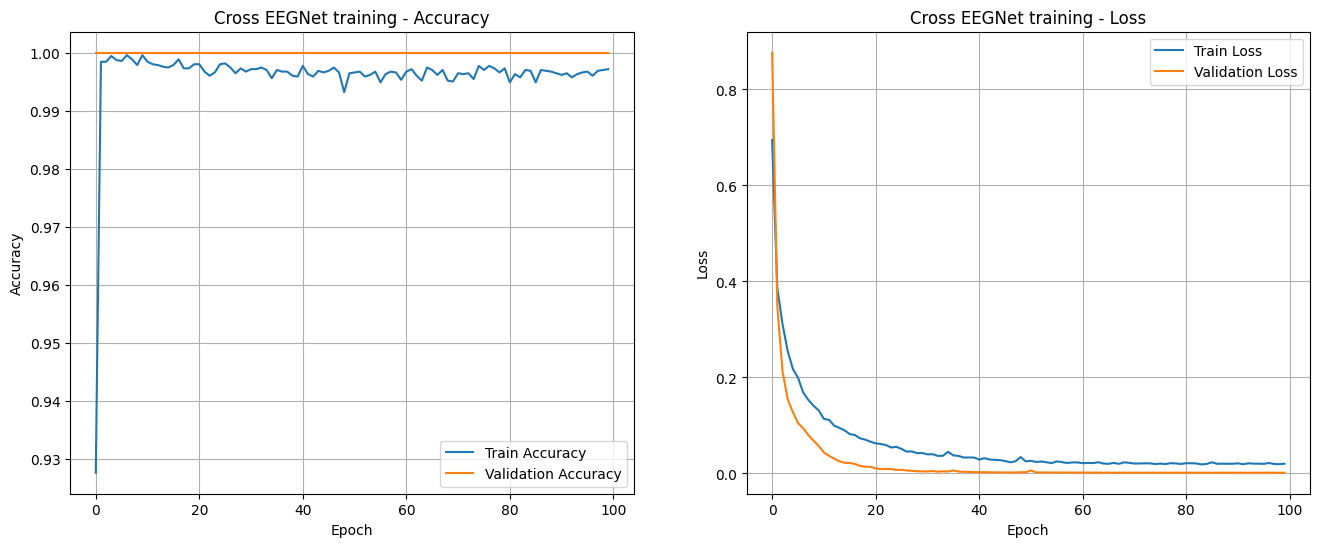

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
report for test set 1:

                     precision    recall  f1-score   support

               rest       1.00      1.00      1.00       276
         task_motor       1.00      1.00      1.00       276
    task_story_math       0.96      1.00      0.98       276
task_working_memory       1.00      0.96      0.98       276

           accuracy                           0.99      1104
          macro avg       0.99      0.99      0.99      1104
       weighted avg       0.99      0.99      0.99      1104

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
report for test set 2:

                     precision    recall  f1-score   support

               rest       1.00      1.00      1.00       276
         task_motor       0.34      0.62      0.44       276
    task_story_math       0.00      0.00      0.00       276
task_working_memory       0.00      0.00      0.00       276

           accuracy                           0.40      1104
          macro

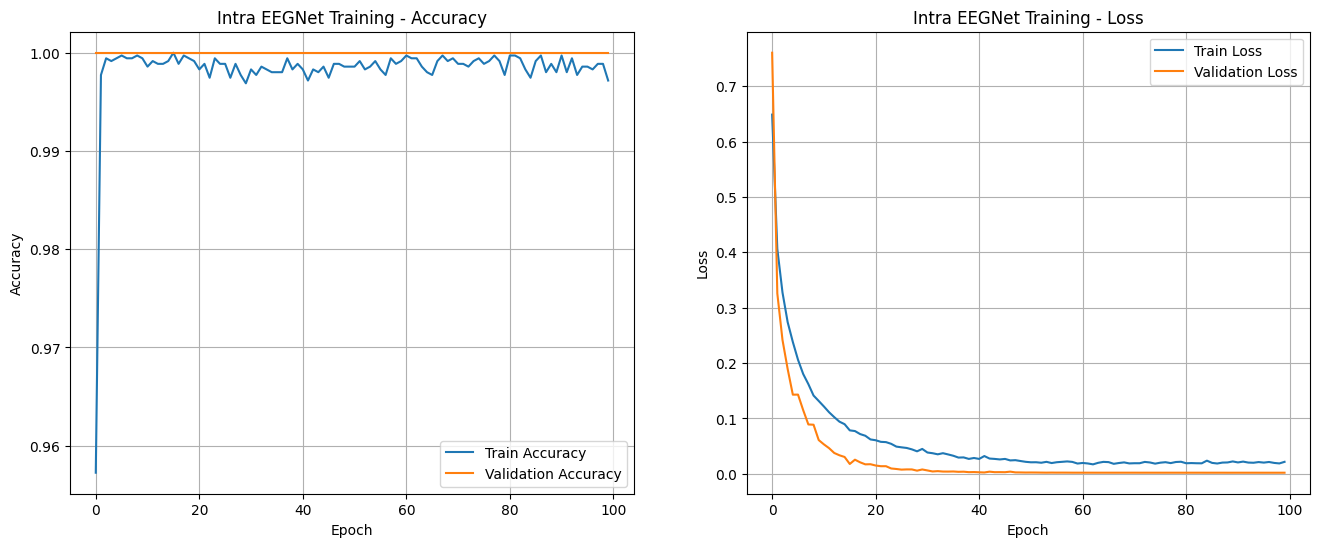

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


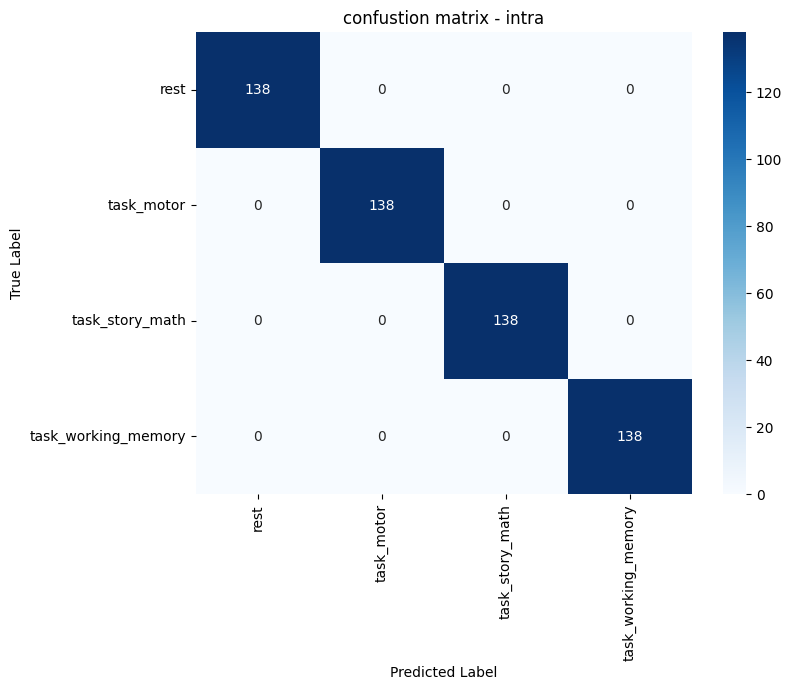

classification report for intra test set:

                     precision    recall  f1-score   support

               rest       1.00      1.00      1.00       138
         task_motor       1.00      1.00      1.00       138
    task_story_math       1.00      1.00      1.00       138
task_working_memory       1.00      1.00      1.00       138

           accuracy                           1.00       552
          macro avg       1.00      1.00      1.00       552
       weighted avg       1.00      1.00      1.00       552



In [23]:
plot_history(history_cross, "Cross EEGNet training")
cross_test_sets = {
    "test set 1": (X_test1_final, y_test1_final),
    "test set 2": (X_test2_final, y_test2_final),
    "test set 3": (X_test3_final, y_test3_final)
}

for name, (data, labels) in cross_test_sets.items():
    y_pred = np.argmax(model.predict(data), axis=1)
    print(f"report for {name}:\n")
    print(classification_report(labels, y_pred, target_names=TASKS))
    # plot_confusion_matrix(y_test_cross_final, y_pred_cross, TASKS, "confustion matrix - cross")

print("analysis for intra:")
plot_history(history_intra, "Intra EEGNet Training")
y_pred_intra = np.argmax(model_intra.predict(X_test_intra_final), axis=1)
plot_confusion_matrix(y_test_intra_final, y_pred_intra, TASKS, "confustion matrix - intra")
print("classification report for intra test set:\n")
print(classification_report(y_test_intra_final, y_pred_intra, target_names=TASKS))